# Method 2 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

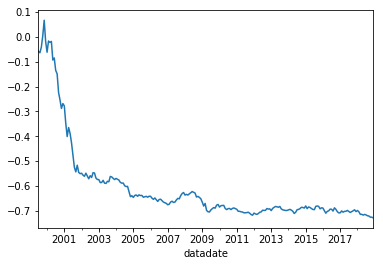

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.018419
2000-12-31   -0.254644
2001-12-31   -0.385689
2002-12-31   -0.051816
2003-12-31   -0.000739
2004-12-31   -0.152342
2005-12-31   -0.006015
2006-12-31   -0.080386
2007-12-31    0.132689
2008-12-31   -0.066859
2009-12-31   -0.066170
2010-12-31   -0.051639
2011-12-31   -0.085635
2012-12-31    0.090818
2013-12-31   -0.021116
2014-12-31    0.032040
2015-12-31    0.003351
2016-12-31   -0.065434
2017-12-31    0.017764
2018-12-31   -0.085703
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     7.752
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.10e-06
Time:                        02:41:04   Log-Likelihood:                 529.74
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.002     -3.212      0.002      -0.009      -0.002
mktrf          0.1349      0.047      2.844      0.005       0.041       0.228
me            -0.0058      0.055     -0.106      0.916      -0.115       0.103
ia            -0.3701      0.084     -4.414      0.000      -0.535      -0.205
roe            0.1656      0.072      2.307      0.022       0.024       0.307
==============================================================================
Omnibus:                       13.348   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.966
Skew:                          -0.409   Prob(JB):                     0.000126
Kurtosis:                       4.084   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     3.280
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0122
Time:                        02:41:04   Log-Likelihood:                 529.74
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.002     -2.759      0.006      -0.010      -0.002
mktrf          0.1349      0.069      1.968      0.049       0.001       0.269
me            -0.0058      0.067     -0.086      0.931      -0.138       0.126
ia            -0.3701      0.109     -3.381      0.001      -0.585      -0.156
roe            0.1656      0.081      2.035      0.042       0.006       0.325
==============================================================================
Omnibus:                       13.348   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.966
Skew:                          -0.409   Prob(JB):                     0.000126
Kurtosis:                       4.084   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.793
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0271
Time:                        02:41:04   Log-Likelihood:                 529.74
No. Observations:                 234   AIC:                            -1049.
Df Residuals:                     229   BIC:                            -1032.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.002     -2.466      0.014      -0.010      -0.001
mktrf          0.1349      0.074      1.831      0.067      -0.010       0.279
me            -0.0058      0.055     -0.105      0.916      -0.114       0.103
ia            -0.3701      0.127     -2.922      0.003      -0.618      -0.122
roe            0.1656      0.090      1.831      0.067      -0.012       0.343
==============================================================================
Omnibus:                       13.348   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.966
Skew:                          -0.409   Prob(JB):                     0.000126
Kurtosis:                       4.084   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     7.257
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.50e-06
Time:                        02:41:04   Log-Likelihood:                 532.16
No. Observations:                 234   AIC:                            -1052.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.002     -2.192      0.029      -0.007      -0.000
mktrf          0.0497      0.047      1.054      0.293      -0.043       0.143
smb           -0.0968      0.062     -1.556      0.121      -0.219       0.026
hml           -0.1173      0.073     -1.600      0.111      -0.262       0.027
rmw           -0.1414      0.083     -1.706      0.089      -0.305       0.022
cma           -0.1717      0.105     -1.629      0.105      -0.379       0.036
==============================================================================
Omnibus:                       18.428   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.430
Skew:                          -0.501   Prob(JB):                     1.11e-06
Kurtosis:                       4.345   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3.164
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00881
Time:                        02:41:04   Log-Likelihood:                 532.16
No. Observations:                 234   AIC:                            -1052.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.002     -2.343      0.019      -0.007      -0.001
mktrf          0.0497      0.058      0.861      0.389      -0.063       0.163
smb           -0.0968      0.083     -1.163      0.245      -0.260       0.066
hml           -0.1173      0.079     -1.477      0.140      -0.273       0.038
rmw           -0.1414      0.098     -1.440      0.150      -0.334       0.051
cma           -0.1717      0.115     -1.494      0.135      -0.397       0.053
==============================================================================
Omnibus:                       18.428   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.430
Skew:                          -0.501   Prob(JB):                     1.11e-06
Kurtosis:                       4.345   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3.962
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00183
Time:                        02:41:04   Log-Likelihood:                 532.16
No. Observations:                 234   AIC:                            -1052.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.002     -2.206      0.027      -0.007      -0.000
mktrf          0.0497      0.063      0.795      0.427      -0.073       0.172
smb           -0.0968      0.073     -1.327      0.184      -0.240       0.046
hml           -0.1173      0.075     -1.571      0.116      -0.264       0.029
rmw           -0.1414      0.091     -1.558      0.119      -0.319       0.036
cma           -0.1717      0.105     -1.629      0.103      -0.378       0.035
==============================================================================
Omnibus:                       18.428   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.430
Skew:                          -0.501   Prob(JB):                     1.11e-06
Kurtosis:                       4.345   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     8.143
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.72e-06
Time:                        02:41:04   Log-Likelihood:                 530.44
No. Observations:                 234   AIC:                            -1051.
Df Residuals:                     229   BIC:                            -1034.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.002     -3.210      0.002      -0.009      -0.002
mktrf          0.1346      0.044      3.091      0.002       0.049       0.220
smb           -0.0563      0.054     -1.036      0.302      -0.163       0.051
hml           -0.2295      0.054     -4.252      0.000      -0.336      -0.123
umd            0.0591      0.035      1.669      0.096      -0.011       0.129
==============================================================================
Omnibus:                       21.307   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.918
Skew:                          -0.522   Prob(JB):                     1.59e-08
Kurtosis:                       4.610   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.662
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000231
Time:                        02:41:04   Log-Likelihood:                 530.44
No. Observations:                 234   AIC:                            -1051.
Df Residuals:                     229   BIC:                            -1034.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.002     -3.089      0.002      -0.009      -0.002
mktrf          0.1346      0.068      1.966      0.049       0.000       0.269
smb           -0.0563      0.046     -1.236      0.217      -0.146       0.033
hml           -0.2295      0.111     -2.069      0.039      -0.447      -0.012
umd            0.0591      0.051      1.155      0.248      -0.041       0.159
==============================================================================
Omnibus:                       21.307   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.918
Skew:                          -0.522   Prob(JB):                     1.59e-08
Kurtosis:                       4.610   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     7.881
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.73e-06
Time:                        02:41:04   Log-Likelihood:                 530.44
No. Observations:                 234   AIC:                            -1051.
Df Residuals:                     229   BIC:                            -1034.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.002     -2.965      0.003      -0.009      -0.002
mktrf          0.1346      0.072      1.859      0.063      -0.007       0.276
smb           -0.0563      0.038     -1.492      0.136      -0.130       0.018
hml           -0.2295      0.120     -1.910      0.056      -0.465       0.006
umd            0.0591      0.054      1.095      0.273      -0.047       0.165
==============================================================================
Omnibus:                       21.307   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.918
Skew:                          -0.522   Prob(JB):                     1.59e-08
Kurtosis:                       4.610   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.839
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.93e-06
Time:                        02:41:04   Log-Likelihood:                 256.71
No. Observations:                 120   AIC:                            -503.4
Df Residuals:                     115   BIC:                            -489.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.003     -3.499      0.001      -0.015      -0.004
mktrf          0.2175      0.075      2.900      0.004       0.069       0.366
me             0.0736      0.074      0.993      0.323      -0.073       0.220
ia            -0.5440      0.116     -4.689      0.000      -0.774      -0.314
roe            0.3684      0.103      3.588      0.000       0.165       0.572
==============================================================================
Omnibus:                        7.693   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.596
Skew:                          -0.494   Prob(JB):                       0.0224
Kurtosis:                       3.737   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.655
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.83e-06
Time:                        02:41:04   Log-Likelihood:                 256.71
No. Observations:                 120   AIC:                            -503.4
Df Residuals:                     115   BIC:                            -489.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.003     -3.061      0.002      -0.016      -0.004
mktrf          0.2175      0.076      2.867      0.004       0.069       0.366
me             0.0736      0.066      1.115      0.265      -0.056       0.203
ia            -0.5440      0.112     -4.861      0.000      -0.763      -0.325
roe            0.3684      0.074      4.953      0.000       0.223       0.514
==============================================================================
Omnibus:                        7.693   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.596
Skew:                          -0.494   Prob(JB):                       0.0224
Kurtosis:                       3.737   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     6.776
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.22e-05
Time:                        02:41:04   Log-Likelihood:                 256.71
No. Observations:                 120   AIC:                            -503.4
Df Residuals:                     115   BIC:                            -489.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.004     -2.758      0.006      -0.017      -0.003
mktrf          0.2175      0.070      3.113      0.002       0.081       0.354
me             0.0736      0.054      1.363      0.173      -0.032       0.179
ia            -0.5440      0.123     -4.408      0.000      -0.786      -0.302
roe            0.3684      0.076      4.876      0.000       0.220       0.516
==============================================================================
Omnibus:                        7.693   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.596
Skew:                          -0.494   Prob(JB):                       0.0224
Kurtosis:                       3.737   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     5.527
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000136
Time:                        02:41:04   Log-Likelihood:                 253.65
No. Observations:                 120   AIC:                            -495.3
Df Residuals:                     114   BIC:                            -478.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.003     -2.265      0.025      -0.012      -0.001
mktrf          0.0375      0.081      0.460      0.647      -0.124       0.199
smb           -0.0636      0.092     -0.689      0.492      -0.246       0.119
hml           -0.1685      0.113     -1.490      0.139      -0.393       0.056
rmw           -0.0663      0.133     -0.497      0.620      -0.331       0.198
cma           -0.2746      0.146     -1.879      0.063      -0.564       0.015
==============================================================================
Omnibus:                        8.433   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.668
Skew:                          -0.508   Prob(JB):                       0.0131
Kurtosis:                       3.838   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     5.090
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000300
Time:                        02:41:04   Log-Likelihood:                 253.65
No. Observations:                 120   AIC:                            -495.3
Df Residuals:                     114   BIC:                            -478.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.003     -2.494      0.013      -0.012      -0.001
mktrf          0.0375      0.068      0.550      0.582      -0.096       0.171
smb           -0.0636      0.106     -0.602      0.547      -0.271       0.143
hml           -0.1685      0.119     -1.411      0.158      -0.403       0.065
rmw           -0.0663      0.128     -0.518      0.605      -0.317       0.185
cma           -0.2746      0.131     -2.094      0.036      -0.532      -0.018
==============================================================================
Omnibus:                        8.433   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.668
Skew:                          -0.508   Prob(JB):                       0.0131
Kurtosis:                       3.838   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     8.601
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.12e-07
Time:                        02:41:04   Log-Likelihood:                 253.65
No. Observations:                 120   AIC:                            -495.3
Df Residuals:                     114   BIC:                            -478.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.003     -2.346      0.019      -0.012      -0.001
mktrf          0.0375      0.065      0.575      0.565      -0.090       0.165
smb           -0.0636      0.090     -0.706      0.480      -0.240       0.113
hml           -0.1685      0.114     -1.484      0.138      -0.391       0.054
rmw           -0.0663      0.118     -0.564      0.573      -0.297       0.164
cma           -0.2746      0.115     -2.395      0.017      -0.499      -0.050
==============================================================================
Omnibus:                        8.433   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.668
Skew:                          -0.508   Prob(JB):                       0.0131
Kurtosis:                       3.838   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     6.572
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.46e-05
Time:                        02:41:04   Log-Likelihood:                 252.98
No. Observations:                 120   AIC:                            -496.0
Df Residuals:                     115   BIC:                            -482.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080      0.003     -2.836      0.005      -0.014      -0.002
mktrf          0.1581      0.068      2.319      0.022       0.023       0.293
smb           -0.0783      0.078     -1.008      0.315      -0.232       0.075
hml           -0.3020      0.078     -3.884      0.000      -0.456      -0.148
umd            0.0769      0.048      1.604      0.111      -0.018       0.172
==============================================================================
Omnibus:                       11.431   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.486
Skew:                          -0.577   Prob(JB):                      0.00118
Kurtosis:                       4.168   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.264
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000626
Time:                        02:41:04   Log-Likelihood:                 252.98
No. Observations:                 120   AIC:                            -496.0
Df Residuals:                     115   BIC:                            -482.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080      0.003     -2.967      0.003      -0.013      -0.003
mktrf          0.1581      0.088      1.788      0.074      -0.015       0.331
smb           -0.0783      0.061     -1.287      0.198      -0.197       0.041
hml           -0.3020      0.124     -2.435      0.015      -0.545      -0.059
umd            0.0769      0.054      1.412      0.158      -0.030       0.184
==============================================================================
Omnibus:                       11.431   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.486
Skew:                          -0.577   Prob(JB):                      0.00118
Kurtosis:                       4.168   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.839
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.93e-06
Time:                        02:41:04   Log-Likelihood:                 252.98
No. Observations:                 120   AIC:                            -496.0
Df Residuals:                     115   BIC:                            -482.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080      0.003     -2.862      0.004      -0.013      -0.003
mktrf          0.1581      0.079      1.998      0.046       0.003       0.313
smb           -0.0783      0.051     -1.527      0.127      -0.179       0.022
hml           -0.3020      0.120     -2.516      0.012      -0.537      -0.067
umd            0.0769      0.054      1.420      0.156      -0.029       0.183
==============================================================================
Omnibus:                       11.431   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.486
Skew:                          -0.577   Prob(JB):                      0.00118
Kurtosis:                       4.168   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9071
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.463
Time:                        02:41:04   Log-Likelihood:                 299.50
No. Observations:                 114   AIC:                            -589.0
Df Residuals:                     109   BIC:                            -575.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.334      0.739      -0.004       0.003
mktrf          0.0345      0.053      0.656      0.513      -0.070       0.139
me            -0.1173      0.081     -1.444      0.151      -0.278       0.044
ia             0.0351      0.113      0.311      0.756      -0.188       0.258
roe           -0.1375      0.099     -1.390      0.167      -0.334       0.059
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.489
Skew:                           0.105   Prob(JB):                        0.783
Kurtosis:                       2.757   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     1.220
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.306
Time:                        02:41:04   Log-Likelihood:                 299.50
No. Observations:                 114   AIC:                            -589.0
Df Residuals:                     109   BIC:                            -575.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.356      0.722      -0.004       0.003
mktrf          0.0345      0.084      0.409      0.683      -0.131       0.200
me            -0.1173      0.072     -1.622      0.105      -0.259       0.024
ia             0.0351      0.088      0.397      0.692      -0.138       0.208
roe           -0.1375      0.078     -1.752      0.080      -0.291       0.016
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.489
Skew:                           0.105   Prob(JB):                        0.783
Kurtosis:                       2.757   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     1.314
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.269
Time:                        02:41:04   Log-Likelihood:                 299.50
No. Observations:                 114   AIC:                            -589.0
Df Residuals:                     109   BIC:                            -575.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.360      0.719      -0.004       0.003
mktrf          0.0345      0.095      0.363      0.716      -0.152       0.221
me            -0.1173      0.072     -1.638      0.102      -0.258       0.023
ia             0.0351      0.086      0.406      0.685      -0.134       0.204
roe           -0.1375      0.068     -2.025      0.043      -0.271      -0.004
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.489
Skew:                           0.105   Prob(JB):                        0.783
Kurtosis:                       2.757   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.4793
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.791
Time:                        02:41:04   Log-Likelihood:                 298.89
No. Observations:                 114   AIC:                            -585.8
Df Residuals:                     108   BIC:                            -569.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.546      0.586      -0.005       0.003
mktrf          0.0335      0.051      0.661      0.510      -0.067       0.134
smb           -0.0855      0.082     -1.040      0.301      -0.249       0.077
hml           -0.0671      0.105     -0.640      0.524      -0.275       0.141
rmw           -0.0957      0.128     -0.745      0.458      -0.350       0.159
cma            0.1717      0.163      1.053      0.295      -0.151       0.495
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.771
Skew:                           0.149   Prob(JB):                        0.680
Kurtosis:                       2.728   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.6047
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.696
Time:                        02:41:04   Log-Likelihood:                 298.89
No. Observations:                 114   AIC:                            -585.8
Df Residuals:                     108   BIC:                            -569.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.571      0.568      -0.004       0.002
mktrf          0.0335      0.083      0.404      0.686      -0.129       0.196
smb           -0.0855      0.069     -1.243      0.214      -0.220       0.049
hml           -0.0671      0.153     -0.439      0.661      -0.367       0.233
rmw           -0.0957      0.176     -0.543      0.587      -0.441       0.250
cma            0.1717      0.148      1.164      0.245      -0.118       0.461
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.771
Skew:                           0.149   Prob(JB):                        0.680
Kurtosis:                       2.728   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.8759
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.500
Time:                        02:41:04   Log-Likelihood:                 298.89
No. Observations:                 114   AIC:                            -585.8
Df Residuals:                     108   BIC:                            -569.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.564      0.573      -0.004       0.002
mktrf          0.0335      0.094      0.354      0.723      -0.152       0.219
smb           -0.0855      0.062     -1.375      0.169      -0.207       0.036
hml           -0.0671      0.137     -0.489      0.625      -0.336       0.202
rmw           -0.0957      0.174     -0.549      0.583      -0.437       0.246
cma            0.1717      0.138      1.246      0.213      -0.098       0.442
==============================================================================
Omnibus:                        0.638   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.771
Skew:                           0.149   Prob(JB):                        0.680
Kurtosis:                       2.728   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5129
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.726
Time:                        02:41:04   Log-Likelihood:                 298.70
No. Observations:                 114   AIC:                            -587.4
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.672      0.503      -0.005       0.002
mktrf          0.0434      0.050      0.865      0.389      -0.056       0.143
smb           -0.0656      0.078     -0.838      0.404      -0.221       0.090
hml            0.0443      0.081      0.550      0.584      -0.115       0.204
umd            0.0680      0.061      1.118      0.266      -0.053       0.188
==============================================================================
Omnibus:                        1.817   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.794
Skew:                           0.297   Prob(JB):                        0.408
Kurtosis:                       2.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.3944
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.812
Time:                        02:41:04   Log-Likelihood:                 298.70
No. Observations:                 114   AIC:                            -587.4
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.703      0.482      -0.005       0.002
mktrf          0.0434      0.079      0.552      0.581      -0.111       0.198
smb           -0.0656      0.065     -1.010      0.313      -0.193       0.062
hml            0.0443      0.124      0.357      0.721      -0.199       0.287
umd            0.0680      0.066      1.027      0.304      -0.062       0.198
==============================================================================
Omnibus:                        1.817   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.794
Skew:                           0.297   Prob(JB):                        0.408
Kurtosis:                       2.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5963
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.666
Time:                        02:41:04   Log-Likelihood:                 298.70
No. Observations:                 114   AIC:                            -587.4
Df Residuals:                     109   BIC:                            -573.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.714      0.475      -0.005       0.002
mktrf          0.0434      0.088      0.493      0.622      -0.129       0.216
smb           -0.0656      0.063     -1.046      0.295      -0.188       0.057
hml            0.0443      0.113      0.390      0.696      -0.178       0.267
umd            0.0680      0.054      1.252      0.211      -0.038       0.174
==============================================================================
Omnibus:                        1.817   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.794
Skew:                           0.297   Prob(JB):                        0.408
Kurtosis:                       2.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""